<div style="float:left"><h1>  Your Personalized Food Travel Guide: Yelp Recommender System</h1></div>


**Author:** Alex Xue 

**Contact:** alex.xue15@gmail.com

**Date:** December 12th

## Table Of Contents 
1. [Introduction to this Notebook](#Introduction-to-this-Notebook)
2. [Loading in Previous Work](#Loading-in-Previous-Work )
3. [Collaborative Filtering](#Collaborative-Filtering)
3. [Conclusion to this Notebook](#Conclusion-to-this-Notebook)

## Introduction to this Notebook

In this notebook we'll be finishing off the project. This notebook will primarily focused on collaborative filtering and the methods to evaluate and iterate through models. In the end, we'll discuss next steps for the whole project.  

## Loading in Previous Work 

In this section we'll be reading in the final dataset that we previously worked on in the past notebooks. We'll also be doing a similar process of loading in the reviews dataset, and merging it with the business dataset, to only get the reviews relevant to our businesses.

In [1]:
import numpy as np #Import numpy 
import pandas as pd #Import Pandas
import matplotlib.pyplot as plt #import matplotlib
import seaborn as sns #import Seaborn 

In [2]:
#Reading in the df_business_final dataframe
df_business_final=pd.read_csv("data/df_final.csv",index_col=0)

In [3]:
#reading in the review dataframe
df_reviews=pd.read_csv("data/Yelp_dataset_old/yelp_review.csv")

In [4]:
#renaming the columns to make sure it isn't competing names 
df_reviews=df_reviews.rename(columns={'stars':'Review_star'})

After we've loaded in our reviews dataset, we need to rename the stars column to not confuse it with the business average stars.

In [5]:
#taking a look at the first 5 rows of this dataframe 
df_reviews.head()

,review_id,user_id,business_id,Review_star,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [6]:
#Creating the merged dataframe on buisness_id
df_reviews_merged=pd.merge(df_business_final,df_reviews,on='business_id',how='left')

Now that we have the two dataframes we'll be needing from our previous notebooks, we can move on to collaborative filtering.

### Collaborative Filtering

Collaborative Filtering is a method of creating a recommender system where essentially we will be recommending different restaurants based on similar users. This type of filtering is good when you have a lot of data, as it's more likely you'll find similar users to yourself. However, this creates one big problem which is the cold start problem from earlier. It's very difficult to find users similar to a user in a meaningful way unless you have a substantial amount of data on the user. A single restaurant isn't going to be very informative in this method, unlike in the content based one where a single restaurant could reasonably give restaurants similar to that restaurant. Another problem that we'll address is that the method we're using today, which is a version of a SVD or singular value decomposition, generates what are called latent variables. These latent variables can be used to describe restaurants and users based on the reviews that user has given or the restaurant has. One issue that we'll see, is that there isn't a good way to incorporate a new user as the only way to do that would be to refit the whole dataset. The last problem the SVD has which is along the same lines, is that once we've used the validation set to optimize our hyper-parameters, there isn't a good way to refit our data on both the train and validation. However, that being said, collaborative filtering and FunkSVDs have huge benefits since it's looking for similar users instead of similar restaurants. There also is more of a definitive method of evaluating SVDs compared to the way we used for our content-based filtering.

In [7]:
from surprise import Dataset #Importing Dataset
from surprise.reader import Reader #Importing Reader
from surprise.prediction_algorithms.matrix_factorization import SVD as FunkSVD #importing FunkSVD
from surprise import accuracy #importing accuracy 
from surprise.model_selection import train_test_split #importing train test split from surprise 
from sklearn.model_selection import train_test_split as train_test_split_reg #importing train-test-split from regular sklearn

To start lets import our different libraries we'll be needed.

In [8]:
#Creating df_reviews_suprise 
df_reviews_suprise=df_reviews_merged[['user_id','business_id','Review_star']]

In [9]:
#Looking at the columns in df_reviews_suprise 
df_reviews_suprise.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1694008 entries, 0 to 1694007
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      object
 1   business_id  object
 2   Review_star  int64 
dtypes: int64(1), object(2)
memory usage: 51.7+ MB


Looking at the reviews dataframe we've created,  we can see just under 1.7 million different reviews. Lets take a look at how many unique users this is.

In [10]:
#Looking at unique user_ids
df_reviews_suprise['user_id'].nunique()

475353

We can see that its just over 470k unique users in our dataframe. That averages out to about 4 reviews per person.

In [11]:
#Looking at the unique businesses 
df_reviews_suprise['business_id'].nunique()

26506

Below is where we're going to load our dataframe into a special loader from surprise. This is also why we needed to create `df_reviews_suprise` in the first place as the dataset needs to be in a certain format to pass through the loader. In our case we made the `user_id` the first column to make it the resulting U matrix that will come out of the model. Also we needed to make sure the shape of the dataframe was also correct.

In [12]:
# Loading in the dataset loader using sklearn suprise dataset class and Reader class
my_dataset = Dataset.load_from_df(df_reviews_suprise, Reader(rating_scale=(1, 5)))
#Train test split using the suprise train test split
my_train_dataset_eval, my_test_dataset = train_test_split(my_dataset, test_size=0.3,random_state=24)
#Train test split on the test dataset to split it into validation and test
validation_dataset_eval, my_test_dataset_eval = train_test_split_reg(my_test_dataset, test_size=0.3,random_state=24)

Looking above, what we do after we load it into the reader is that we split it into train and test using the train_test_split from surprise. We then use the regular train test split from sklearn to split the test into validation and test. This is different than what is usually done because the train test split from surprise changes the training data into a specific object that can be passed through FunkSVD. As a result we wouldn't be able to split it into it's validation.

In [13]:
#Creating my funksvd algorithm 
my_algorithm = FunkSVD(n_factors=10, #Number of latent factors 
                       n_epochs=50,  #Number of epochs
                       lr_all=0.05,    # Learning rate for each epoch
                       biased=False,  # This forces the algorithm to store all latent information in the matrices
                       verbose=1)

my_algorithm.fit(my_train_dataset_eval) #fitting on the train dataset

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49


In [14]:
#getting the user latent variable dataframe 
U = my_algorithm.pu
#Checking the shape
U.shape

(386814, 10)

When we take a look at the number of users, we're seeing that we have a lowered amount which is concerning. This is likely due to the train test split. The issue with this however, is that if a user isn't in the dataset that we're training on, we can't recommend that user restaurants. Lets take a look at businesses and see if we see a similar issue.

In [15]:
#assigning the User similarity to a dataframe
User_similarity=pd.DataFrame(U)

In [16]:
#checking the null values
pd.DataFrame(U).isna().sum().sum()

0

In [17]:
#getting the restaruants latent variable dataframe 
M = my_algorithm.qi.T
#checking the shape
M.shape

(10, 26432)

Taking a look at the business shape, we see a similar issue of losing ~600 businesses. With these two issues, we decided just for the part where we are actually recommending restaurants, to include the full dataset. The evaluation and hyperparameter tuning will be done using the train and validation split however. This was a decision made to not lose users and businesses. 

### Doing it on the full dataset instead

Here we're doing the same training on the full dataset now.

In [18]:
# Loading in the dataset loader using sklearn suprise dataset class and Reader class
my_dataset = Dataset.load_from_df(df_reviews_suprise, Reader(rating_scale=(1, 5)))
#Train test split using the suprise train test split
my_train_dataset = my_dataset.build_full_trainset()

In [19]:
my_algorithm = FunkSVD(n_factors=10, #Number of latent factors 
                       n_epochs=50, #Number of epochs
                       lr_all=0.05,    # Learning rate for each epoch
                       biased=False,  # This forces the algorithm to store all latent information in the matrices
                       verbose=1)

my_algorithm.fit(my_train_dataset) #fitting on the train dataset 

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49


As a starting point, we'll use the number of factors of 10, the number of epochs as 50 and a learning rate of 0.05. The epochs is the number of iterations the algorithm goes through the stochastic gradient descent process which is used to optimize the algorithm. The learning rate is just a measure of how much information should be gained by each epoch. 

In [20]:
#getting the user latent variable dataframe
U = my_algorithm.pu
#checking the shape
U.shape

(475353, 10)

Immediately, we're not seeing the same loss in users which is a good sign.

In [21]:
#Creating a dataframe based on the user latent variable dataframe 
User_similarity=pd.DataFrame(U)

In [22]:
#checking the null values 
pd.DataFrame(U).isna().sum().sum()

0

In [23]:
#Getting the Restaurant latent variable dataframe 
M = my_algorithm.qi.T
#checking the shape 
M.shape

(10, 26506)

Additionally, we're not seeing any loss in businesses.

In [24]:
#Creating the dataframe for restaurant similarity 
Restaurant_similarity= pd.DataFrame(M).T

In [25]:
#looking at the first 5 rows 
Restaurant_similarity.head()

,0,1,2,3,4,5,6,7,8,9
0,-1.137735,-0.282039,-2.319226,0.491317,-0.259505,-0.093593,-0.356628,-0.419426,1.293489,-1.031921
1,-0.921441,-1.177312,-1.129939,-1.066735,0.034532,-0.865482,-0.520820,0.525317,0.248036,-0.962947
2,-0.475301,-1.300420,-1.434343,-0.287002,0.087782,-0.348419,-0.109258,1.035132,1.488339,-0.339143
3,-0.203296,-0.199091,-1.129495,0.019291,-0.852114,0.955748,-1.185956,0.257772,1.557960,-0.771782
4,-1.148941,0.238905,-1.513459,0.763848,0.227564,1.643208,-1.429435,0.778520,-0.304543,-0.557427


Displayed above is what the dataframes made from these U and M matrices look like. In our case since we picked 10 latent variables, we have 10 columns. 

In [26]:
#Looking at the first restaurant 
First_Restaurant = M[:, 0]
First_Restaurant

array([-1.13773456, -0.28203892, -2.31922623,  0.49131662, -0.25950542,
       -0.09359271, -0.35662778, -0.41942574,  1.29348941, -1.03192052])

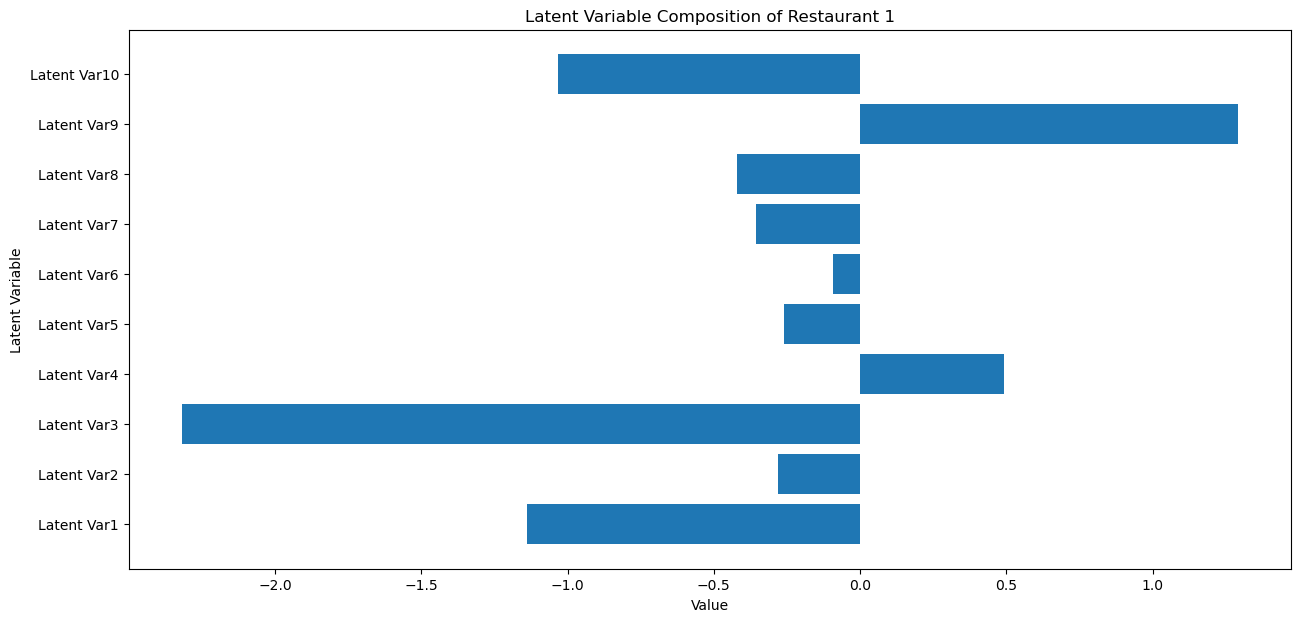

In [112]:
#Looking at the 1st restaurant latent variables
First_Restaurant = M[:, 0]

plt.figure(figsize=(15, 7)) #plotting figure 
plt.barh([f'Latent Var{i}' for i in range(1,len(First_Restaurant)+1)], First_Restaurant) #plotting on a bar graph
plt.title("Latent Variable Composition of Restaurant 1") 
plt.ylabel("Latent Variable")
plt.xlabel("Value")
plt.show() #showing the figure 

We can also plot the values of these latent variables and compare them to each other. In this case we see that the first restaurant has a very high value in latent 9 but not as much elsewhere. The more latent variables that we have, the more information we have on the business. However too many can cause for over segregating which is not ideal in the case of a recommender system. The premise is we'll need to optimize this number where we can create distinct groupings that are representative of restaurants.  

In [29]:
#Taking a look at the first one
df_reviews_suprise[0:1]

,user_id,business_id,Review_star
0,JnXYIUYuFkGGxgneBkmeBw,xcgFnd-MwkZeO5G2HQ0gAQ,5


taking a look at one of the users we have here, we'll use them as an example to find their hidden profile. Their hidden profile will be their collection of latent variables. We can then dot product any business with the user profile to find the models expected rating for that business. A disclaimer though is that the model will predict floats when ratings were only 1-5 unique integers.

In [30]:
#Assigning The first restaurnt 
First_Restaurant = M[:, 0]

In [31]:
inner_user_id = my_train_dataset.to_inner_uid('JnXYIUYuFkGGxgneBkmeBw') # find the inner representation of user 1
user_profile = U[inner_user_id] #Assigning the latent variable to the user_profile
user_profile

array([-0.70258507, -0.62191456, -1.27317313,  0.06018337, -0.315623  ,
        0.71711829,  0.15475668,  0.23897274,  0.4250856 , -0.57805305])

Here we found the inner profile of our user

In [32]:
inner_restaurant_id = my_train_dataset.to_inner_iid('xcgFnd-MwkZeO5G2HQ0gAQ') # find the inner representation of item 1
restaurant_profile = M[:, inner_restaurant_id] #assigning the inner representation to restaurant profile 
restaurant_profile

array([-1.13773456, -0.28203892, -2.31922623,  0.49131662, -0.25950542,
       -0.09359271, -0.35662778, -0.41942574,  1.29348941, -1.03192052])

Here we found the inner profile of a restaurant.

In [33]:
expected_rating = np.dot(user_profile, restaurant_profile) #finding the expected rating 
expected_rating

4.96282055460544

Here we see that the expected rating for this restaurant is 4.96, which would be a positive rating.

### Creating a function for ranking

Here we'll work towards creating a function that can rank all the businesses for a user.

In [34]:
#printing the first 5 User_id
df_reviews_suprise['user_id'][0:5]

0    JnXYIUYuFkGGxgneBkmeBw
1    PBV_oQCoABX958-zjiLGwQ
2    _f5fHijZb6xocu_jNeZvPA
3    148jNH5eI1ZHXLOm1DHiFg
4    abG99DJ23yOBkhaqICuFyA
Name: user_id, dtype: object

We'll start by selecting a user, in this case the second one.

In [40]:
#Selecting a user
user_id_test='PBV_oQCoABX958-zjiLGwQ'

In [41]:
#Making a test user df
test_user=df_reviews_suprise[df_reviews_suprise['user_id'].str.contains(user_id_test)]

We can then create the test users dataframe, but selecting only rows where the user_id is the same as the user id we selected.

In [42]:
test_user.head()

,user_id,business_id,Review_star
1,PBV_oQCoABX958-zjiLGwQ,xcgFnd-MwkZeO5G2HQ0gAQ,2
588,PBV_oQCoABX958-zjiLGwQ,spDZkD6cp0JUUm6ghIWHzA,1
46531,PBV_oQCoABX958-zjiLGwQ,UkWme3kwg6L9rd4tCNB15w,2
53111,PBV_oQCoABX958-zjiLGwQ,XiMvHK4Nq0xPa1GOtdKzdA,4
68391,PBV_oQCoABX958-zjiLGwQ,XCxxPZ3Lu5mwmIo7IQRf1g,2


Here we can see that they all share the same user_id but have different business_ids. This however isn't a given assumption, a person could give multiple reviews to the same business. So to start, we'll need to remove the businesses the user has gone too.

In [43]:
#getting the indexs from the test user df
index_user=test_user.index

In [44]:
#Getting the relevant business ID's
business_id_list = []
#iterating over the indexes in the user
for index in index_user:
    #for every index, taking out the business ID
    current_business_id=df_reviews_suprise[df_reviews_suprise.index==index]['business_id'][index]
    #appending the business ID to a list 
    business_id_list.append(current_business_id)
    #getting unique business_ids only 
business_id_list=list(set(business_id_list))

Above, we're iterating over the indexes of the reviews from the user, and matching them with our `df_reviews_suprise` in order to get the business_ids of the restaurant that the user has gone too. We are then going to make this list a set in order to only get the unique values from them. Below, we'll drop all the indexes in this list. 

In [45]:
#input from previous: business_id_list
#Taking a list of business_ids and dropping all businesses that the user has gone to already 
df_new_business=df_business_final.copy()
i=0
#dropping all the business_ids in the list 
for business_id in business_id_list:
    index_value=df_new_business[df_new_business['business_id']== business_id_list[i]].index
    df_new_business.drop(index_value[0],axis=0,inplace=True)
    i+=1

In [46]:
len(business_id_list)==df_business_final.shape[0]-df_new_business.shape[0] #sanity check 

True

We perform a quick sanity check to make sure that the lengths align.

The last step would be to get a business_id, and compare the dot product between the two to get an expected rating which we've done below for a single example. The example is analogous to what we had before.  

In [47]:
new_business_id=df_new_business[0:1]['business_id'] #extracting a single business ID

In [48]:
type(new_business_id[1]) #checking to make sure it's a string 

str

In [49]:
inner_restaurant_id = my_train_dataset.to_inner_iid(new_business_id[1])# find the inner representation of item 1
restaurant_profile = M[:, inner_restaurant_id] #Assiging the representation to a variable 
restaurant_profile

array([-0.92144124, -1.17731244, -1.12993903, -1.06673475,  0.03453154,
       -0.86548247, -0.52081969,  0.5253173 ,  0.24803624, -0.96294707])

In [50]:
inner_user_id = my_train_dataset.to_inner_uid(user_id_test) # find the inner representation of user 1
user_profile = U[inner_user_id] #assiging the user profile 
user_profile

array([ 0.3042436 ,  0.04025024, -0.85908747,  0.05852195, -1.12483084,
        0.09620617, -0.30971526,  0.56304629,  0.69572264, -1.11589054])

The difference here is that instead of printing out a single expected rating, we'll be appending the result into a list. This is to emulate the process that a for loop would do.

In [51]:
expected_ratings=[] #creating the empty list

In [52]:
expected_ratings.append(np.dot(user_profile, restaurant_profile)) #appending the rating to the expected rating 

### Creating it as a loop

Speaking of for loops, now lets create a for loop for what we've just done. 

In [54]:
df_new_business=df_new_business.reset_index().drop(columns='index') #resetting the index 

We are resetting the index in this case to make iterating over the dataframe a bit easier.

In [55]:
df_new_business.shape[0] #checking the new shape

26429

We can see that our dataframe has dropped some businesses, presumably the ones that the user has been to before. 

In [59]:
#input: taking the user_profile established before

import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

expected_ratings=[] #creating an empty list
#iterating over the shape of the dataframe
for i in range(0,df_new_business.shape[0]):
    print(f"Working on n={round(i,1)}...", end="\r") #PROTIP for progress bars...
    #grabbing the ID of a business
    new_business_id=df_new_business[i:i+1]['business_id'][i]
    inner_restaurant_id = my_train_dataset.to_inner_iid(new_business_id) # find the inner representation of the business
    
    restaurant_profile = M[:, inner_restaurant_id] #assigning it to a variable called restaurant profile 
    
    expected_ratings.append(np.dot(user_profile, restaurant_profile)) #appending the dot product between the user and restaurant 

Above is our for loop to iterate over all the remaining businesses and get the expected rating by dot producting the user profile and restaurant profile. we'll now work towards concatting it with our `df_new_business`.

In [60]:
#selecting specific columns
df_new_business=df_new_business[['business_id','name','state','review_count']] 

Here we're selecting a few columns just for the sake of readability.

In [61]:
#concatting expected ratings with the business 
df_new_business=pd.concat([df_new_business,pd.Series(expected_ratings,name='Expected_rating')],axis=1)

After we've concatted our ratings with our business, we'll filter out only the ones that have at least 25 reviews, then sort by highest expected rating.

In [62]:
#Filtering for only above 25
df_higher_number_rating=df_new_business[df_new_business['review_count']>=25]

In [63]:
#Sorting and getting top 10 
df_higher_number_rating.sort_values(by='Expected_rating',ascending=False).head(10)

,business_id,name,state,review_count,Expected_rating
6956,xMhpJZaj4QT1Soh76-E2CA,"""Feast of Dilli""",ON,51,5.695246
8577,HD10w7sMM9HkF4pM8BlJZQ,"""Pinkerton Snack Bar""",ON,42,5.659331
11379,V3gCqDlgMA7bkswtZ9Uuww,"""LCBO""",ON,44,5.620234
10496,4egAyQgylMPJgngmNGCloA,"""Ann's Congee""",ON,40,5.614027
11503,oRy013Ovh_RtEouO-rGX2A,"""Veggie D'Light""",ON,45,5.596287
7147,yYsHJVVdpsoeIOlvOua-rA,"""Sweet Olenka's""",ON,78,5.593356
23044,741v9WSq3BceeRyBLCvF9g,"""Yunaghi""",ON,29,5.537855
4327,LO3SQIsi1WsM23JYgIgqhA,"""Chuck's Chicken Plus""",ON,29,5.534641
12817,jOqh0eVjqtUOpZ9AZgSazA,"""Grey Gardens""",ON,42,5.515123
4252,zeOJYl5UW4D5u3Vcj6QAoA,"""Azarias""",ON,62,5.508141


We see some restaurants here, but we're only seeing Ontario restaurants. lets filter by Nevada to emulate someone traveling from Toronto to Nevada.

In [64]:
#filtering by State
df_higher_number_rating[df_higher_number_rating['state']=='NV'].sort_values(by='Expected_rating',ascending=False)

,business_id,name,state,review_count,Expected_rating
15025,4JNXUYY8wbaaDmk3BPzlWw,"""Mon Ami Gabi""",NV,7361,5.083791
10526,fg9Pwv9jDwZz0L02nJtGVA,"""Kapit Bahay""",NV,71,4.481494
20417,9WVNvQ1UhzXVMihF2Rhuiw,"""Rigos Taco""",NV,27,4.419454
19144,qr3iie2aA1ddJasU-6N1gQ,"""Mimi' & Coco' Bistro""",NV,45,4.284157
20585,Arx42aGpdfI6XRH9lnKdaQ,"""GlutenZero Bakery""",NV,74,4.243803
...,...,...,...,...,...
14598,pF7994Vz1kuReP9f-4HOng,"""El Pollo Loco""",NV,45,-3.430598
14034,IUm5jbVbC49gAI-q2KrZLA,"""Starbucks""",NV,35,-3.507609
18699,KHROx3AxX8btg70JDPbIqg,"""PT's""",NV,48,-3.580784
11781,0sIppXHcTTOze6cH5e1ihw,"""Oasis Hand Car Wash""",NV,110,-3.705374


We now have a filtered by Nevada and can go visit Mon Ami Gabi right away! Lets now make a function to do everything we just did step by step.

### Making it all a function 

In [66]:
def Collab_filter_results(user,dataframe,my_algorithm,minimum_review,Number_of_rec=10,state=None):
    """
    This is a function that takes a user inputted as a user_id and outputs restaurants that other similar 
    users have liked. 
    
    Input:
    user: user_id as a string 
    dataframe: pandas dataframe that is used to get the restaurants that the user went to 
    my_algorithm: fitted and trained SVD model 
    minimum_review: minimum number of reviews a restaurant thats recommonded should have 
    Number_of_rec: How many recommendations to make
    state: ON or NV
    
    Output: A pandas dataframe with the top recommendations based on other users
    
    
    """
    U = my_algorithm.pu
    
    M = my_algorithm.qi.T
    # find the inner representation of user
    inner_user_id = my_train_dataset.to_inner_uid(user)
    
    user_profile = U[inner_user_id]
    
    test_user=dataframe[dataframe['user_id'].str.contains(user)]
    
    #getting the indexs from the test user df
    index_user=test_user.index
    
    #Getting the relevant business ID's
    business_id_list = []
    for index in index_user:
        current_business_id=dataframe[dataframe.index==index]['business_id'][index]
        business_id_list.append(current_business_id)
    business_id_list=list(set(business_id_list))
    
    #input from previous: business_id_list
    #Taking a list of business_ids and dropping all businesses that the user has gone too already 
    df_new_business=df_business_final.copy()
    i=0
    for business_id in business_id_list:
        index_value=df_new_business[df_new_business['business_id']== business_id_list[i]].index
        df_new_business.drop(index_value[0],axis=0,inplace=True)
        i+=1
        
    len(business_id_list)==df_business_final.shape[0]-df_new_business.shape[0] #sanity check
    
    df_new_business=df_new_business.reset_index().drop(columns='index') #resetting the index 
    
    #input: taking the user_profile established before

    import warnings
    warnings.filterwarnings('ignore') # setting ignore as a parameter

    expected_ratings=[]
    i=0
    for i in range(0,df_new_business.shape[0]):
        print(f"Working on n={round(i,1)}...", end="\r") #PROTIP for progress bars...

        new_business_id=df_new_business[i:i+1]['business_id'][i]
        inner_restaurant_id = my_train_dataset.to_inner_iid(new_business_id) # find the inner representation of item 1
    
        restaurant_profile = M[:, inner_restaurant_id]
    
        expected_ratings.append(np.dot(user_profile, restaurant_profile))
    
    #selecting specific columns
    df_new_business=df_new_business[['business_id','name','state','review_count']] 
    
    #concatting expected ratings with the business 
    df_new_business=pd.concat([df_new_business,pd.Series(expected_ratings,name='Expected_rating')],axis=1)
    
    #Filtering for only above x
    df_higher_number_rating=df_new_business[df_new_business['review_count']>=minimum_review]
    
    #filtering by State
    if state == 'NV' or state == 'ON':
        df_higher_number_rating=df_higher_number_rating[df_higher_number_rating['state']==state].sort_values(by='Expected_rating',ascending=False)

    #Sorting and getting top x 
    df_return=df_higher_number_rating.sort_values(by='Expected_rating',ascending=False).head(Number_of_rec)
    return df_return

To summarize the function we created, we take in user_id as an argument as well as some necessary dataframes and the SVD model. We then ask how many is the minimum number of reviews, then return the number of recommendations the user wants. Lets see it in action!

In [67]:
#Showing the user
user_id_test

'PBV_oQCoABX958-zjiLGwQ'

In my case, I only want restaurants that are above 15 reviews, and i want 10 recommendations from Nevada. 

In [69]:
#Using the Collab Filter method
Collab_filter_results(user=user_id_test,dataframe=df_reviews_suprise,my_algorithm=my_algorithm,minimum_review=15,Number_of_rec=10,state='NV')

,business_id,name,state,review_count,Expected_rating
15025,4JNXUYY8wbaaDmk3BPzlWw,"""Mon Ami Gabi""",NV,7361,5.083791
10656,tH9XWcFavOQ7BHch5YWE2A,"""Edible Arrangements""",NV,17,5.001629
10526,fg9Pwv9jDwZz0L02nJtGVA,"""Kapit Bahay""",NV,71,4.481494
20417,9WVNvQ1UhzXVMihF2Rhuiw,"""Rigos Taco""",NV,27,4.419454
19144,qr3iie2aA1ddJasU-6N1gQ,"""Mimi' & Coco' Bistro""",NV,45,4.284157
21678,LGiUTYgKIYnBBbc6kp6ALg,"""Pizza Hut""",NV,24,4.278356
20585,Arx42aGpdfI6XRH9lnKdaQ,"""GlutenZero Bakery""",NV,74,4.243803
13078,kj1KQgC-mCRV4vYZlWitzg,"""Panda Express""",NV,24,4.116924
6716,atVh8viqTj-sqDJ35tAYVg,"""Beach Cafe""",NV,269,4.102260
10707,K7lWdNUhCbcnEvI0NhGewg,"""Wicked Spoon""",NV,5950,4.092056


Here we're seeing the same top 5 rows. We've now successfully created a recommender system that can filter based on state! One caveat is that the user must be in the dataframe that the model is trained on to be able to recommend restaurants to them, unlike with KNN where we could create users based on restaurants they've been to. 

### Model Evaluation

Now we'll discuss how we can improve our model. In the case of SVD, we'll be using two metrics. There are many different ways to evaluate a recommender system and no consensus on the 'best' method outside of implementing it and getting real-time data. With that being said, we'll be using FCP and MAE. FCP is a measure of how often the model was if it were to pick two random businesses, and say that one of them was rated higher then the other. That means with random change, 50% would be the baseline. MAE is a measure of the error in the expected rating. In this case the baseline would be 2 as if you pick 3 on everything, the absolute maximum MAE you could get is 2 as the ratings range from 1-5.

### Evaluating a single model

In [70]:
my_algorithm_eval = FunkSVD(n_factors=10, 
                       n_epochs=50,    #Number of Epochs
                       lr_all=0.05,    # Learning rate for each epoch
                       biased=False,  # This forces the algorithm to store all latent information in the matrices
                       verbose=1)
my_algorithm_eval.fit(my_train_dataset_eval) #fiting on the train dataset

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49


We'll run the same model we did before but this time on only our train data. 

In [71]:
my_algorithm_eval.pu.shape #looking at the shape of the users

(386814, 10)

In [72]:
my_algorithm_eval.qi.shape #looking at the shape of the restaurants 

(26432, 10)

We can see that we've lost some users and restaurants but thats okay as we're just measuring error in this case.

In [73]:
my_algorithm_eval.test(my_test_dataset[0:1]) #showing what a single prediction looks like 

[Prediction(uid='uAJNBvcJA2kIsGx_sSofEw', iid='FTVDICd-uxoEGYh4pU0pcw', r_ui=4.0, est=2.8958247787796547, details={'was_impossible': False})]

This is what one of the rows would look like after evaluating. We see that the model is guessing 2.89 rating but the real rating was 4.0 on this model.

In [74]:
predictions = my_algorithm_eval.test(my_test_dataset) #getting all the predictions

After we get all the predictions we can see what the FCP and MAE are.

In [75]:
FCP = accuracy.fcp(predictions, verbose=False) #getting the fcp accuracy 
print(FCP)  

0.6044685607326158


In [76]:
# MAE
MAE = accuracy.mae(predictions, verbose=False) #getting the MAE error 
print(MAE)

1.1833815029873933


So we're already seeing some improvements over baseline. The FCP is getting it right 60% of the time while the MAE is over 1 but not close to 2. Lets see if we can improve on these metrics.

### Model Iteration to select the best model

Now that we've done it on a single model, lets optimize our hyper parameters based on these two measures. Usually you would use a gridsearchCV, however in our case fcp was not a native scoring method in the method, so we'll manually loop through the search. We'll be using itertools to do this.

In [77]:
import itertools #importing itertools 

In [78]:
#Creating a hyperparameter grid 
hyper_params={
    'n_factors':[10,15,20,25],
    'n_epochs':[10,50,100],
    'lr_all':[0.01,0.05,0.1],
    'reg_all':[0.01,0.02,0.3],
    
}

We'll start with a broader search and narrow our scope.

In [79]:
#geting the values from that hyperparameter grid
values=hyper_params.values()

In [80]:
#printing out the values from that grid
print (values)

dict_values([[10, 15, 20, 25], [10, 50, 100], [0.01, 0.05, 0.1], [0.01, 0.02, 0.3]])


In [81]:
#using itertools to find every combination 
combinations=list(itertools.product(*values))

Here we're using itertools to produce every combination of our values. This is the same thing that gridsearch would do when going through the combinations of hyperparameters.

In [82]:
#creating a counter 
i=0
#creating empty lists
value_list=[]
FCP_list=[]
MAE_list=[]

#iterating over all combinations 
for value in combinations:
    print(f"Working on n={round(i,1)}...", end="\r") #PROTIP for progress bars...
    value_list.append(value)
    my_algorithm_eval = FunkSVD(n_factors=value[0], 
                       n_epochs=value[1], 
                       lr_all=value[2],    # Learning rate for each epoch 
                       reg_all=value[3],
                       biased=False)  # This forces the algorithm to store all latent information in the matrices
    #fitting the algorithm on the train set
    my_algorithm_eval.fit(my_train_dataset_eval)
    #predict on validation
    predictions = my_algorithm_eval.test(validation_dataset_eval)
    #append FCP and MAE 
    FCP = accuracy.fcp(predictions, verbose=False)
    FCP_list.append(FCP)
    MAE = accuracy.mae(predictions, verbose=False)
    MAE_list.append(MAE)
    i+=1

Now that we have our results after a few hours, we can take a look at the MAE, FCP and the corresponding params.

In [83]:
#Creating a resultant dataframe 
Results_hyper_param=pd.DataFrame({'MAE':MAE_list,'FCP':FCP_list,'Params':value_list})

In [85]:
#Writing the result dataframe 
Results_hyper_param.to_csv('Hyper_param_results.csv',index=True)

In [87]:
#Sorting by MAE
Results_hyper_param.sort_values(by='MAE').head(15)

,MAE,FCP,Params
11,1.088952,0.618423,"(10, 50, 0.01, 0.3)"
5,1.089615,0.607254,"(10, 10, 0.05, 0.3)"
38,1.092640,0.618843,"(15, 50, 0.01, 0.3)"
59,1.093209,0.607699,"(20, 10, 0.05, 0.3)"
32,1.094540,0.608380,"(15, 10, 0.05, 0.3)"
86,1.097728,0.609009,"(25, 10, 0.05, 0.3)"
65,1.098338,0.620379,"(20, 50, 0.01, 0.3)"
47,1.099212,0.619163,"(15, 100, 0.01, 0.3)"
20,1.099739,0.617112,"(10, 100, 0.01, 0.3)"
92,1.100508,0.620658,"(25, 50, 0.01, 0.3)"



MAE is a measure of mean absolute error in the model. This means on average we're seeing the rating be off by 1.07-1.2 stars. For MAE, the number of latent factors is on the lower side with 10,15 appearing in 4/5 in the top 5. However, it's hard to conclude exactly if that was a factor as the differences we're seeing are very small. For the number of epochs, we're seeing both 50 and 10 appear in the top 5 and consisting most of the top 10. For lr_all, were seeing the lower numbers dominate 


In [88]:
#Sorting by FCP
Results_hyper_param.sort_values(by='FCP',ascending=False).head(15)

,MAE,FCP,Params
92,1.100508,0.620658,"(25, 50, 0.01, 0.3)"
65,1.098338,0.620379,"(20, 50, 0.01, 0.3)"
101,1.109838,0.619703,"(25, 100, 0.01, 0.3)"
47,1.099212,0.619163,"(15, 100, 0.01, 0.3)"
38,1.092640,0.618843,"(15, 50, 0.01, 0.3)"
74,1.106734,0.618679,"(20, 100, 0.01, 0.3)"
11,1.088952,0.618423,"(10, 50, 0.01, 0.3)"
20,1.099739,0.617112,"(10, 100, 0.01, 0.3)"
95,1.162833,0.613596,"(25, 50, 0.05, 0.3)"
23,1.165819,0.613497,"(10, 100, 0.05, 0.3)"


For FCPs were seeing Higher latent, higher latent, lower LR and higher regularization. This means that two of the parameters appear to be going in the same direction for both MAE and LR. Both seem to have the 0.01 and 0.3 respectively for these values. They also are trending similarly in the epochs with 50 being the top number, albeit different directions on subsequent values. The latent variables are where we see the most difference, with FCP being on the higher side and MAE being on the lower side. That being said, since we're building a recommender system, being able to predict when one business is better than another feels more important, so we'll go in the direction of the FCP.

### Model 2:

In [89]:
#Creating a hyperparameter grid 
hyper_params={
    'n_factors':[20,25,30,40],
    'n_epochs':[50,75,100],
    'lr_all':[0.001,0.005,0.01],
    'reg_all':[0.3,0.4,0.5],
    
}

For Model 2 we're zooming in on higher number of factors, higher epochs, lower LR and higher Regularization. We'll be doing the same process of creating our combinations and iterating through them using a for loop. 

In [90]:
values=hyper_params.values()
#using itertools to find every combination 
combinations=list(itertools.product(*values))

In [91]:
#Counter
i=0
#empty lists
value_list=[]
FCP_list=[]
MAE_list=[]
#iteraiting over all combinations
for value in combinations:
    print(f"Working on n={round(i,1)}...", end="\r") #PROTIP for progress bars...
    value_list.append(value)
    my_algorithm_eval = FunkSVD(n_factors=value[0], 
                       n_epochs=value[1], 
                       lr_all=value[2],    # Learning rate for each epoch 
                       reg_all=value[3],
                       biased=False)  # This forces the algorithm to store all latent information in the matrices
    #fitting on the train dataset 
    my_algorithm_eval.fit(my_train_dataset_eval)
    #evaluating on valdiation
    predictions = my_algorithm_eval.test(validation_dataset_eval)
    #appending FCP and MAE
    FCP = accuracy.fcp(predictions, verbose=False)
    FCP_list.append(FCP)
    MAE = accuracy.mae(predictions, verbose=False)
    MAE_list.append(MAE)
    i+=1

Now that we've gotten our results, we'll make it a dataframe to see what we're getting.

In [93]:
#Creating a resultant df
Results_hyper_param2=pd.DataFrame({'MAE':MAE_list,'FCP':FCP_list,'Params':value_list})

In [94]:
#Sorting by FCP
Results_hyper_param2.sort_values(by='FCP',ascending=False).head(15)

,MAE,FCP,Params
56,1.930388,0.700440,"(30, 50, 0.001, 0.5)"
29,1.929327,0.700416,"(25, 50, 0.001, 0.5)"
2,1.937517,0.698210,"(20, 50, 0.001, 0.5)"
83,1.909567,0.697457,"(40, 50, 0.001, 0.5)"
28,1.872477,0.688084,"(25, 50, 0.001, 0.4)"
1,1.859556,0.682615,"(20, 50, 0.001, 0.4)"
82,1.838675,0.679041,"(40, 50, 0.001, 0.4)"
55,1.830766,0.676263,"(30, 50, 0.001, 0.4)"
27,1.766091,0.661094,"(25, 50, 0.001, 0.3)"
54,1.745667,0.660206,"(30, 50, 0.001, 0.3)"


Sorting by FCP we're seeing some wild increases. FCP is just above 70% but the MAE has shot up to 1.93. While a increase in FCP is nice, an almost double MAE is concerning. Lets take a look at the MAE and see what the numbers look like there.

In [95]:
#Sorting by MAE
Results_hyper_param2.sort_values(by='MAE',ascending=True).head(15)

,MAE,FCP,Params
6,1.093920,0.620420,"(20, 50, 0.01, 0.3)"
15,1.098110,0.619221,"(20, 75, 0.01, 0.3)"
33,1.101606,0.620845,"(25, 50, 0.01, 0.3)"
60,1.104135,0.620718,"(30, 50, 0.01, 0.3)"
42,1.104979,0.620832,"(25, 75, 0.01, 0.3)"
24,1.106694,0.619781,"(20, 100, 0.01, 0.3)"
69,1.107531,0.620411,"(30, 75, 0.01, 0.3)"
21,1.109029,0.623285,"(20, 100, 0.005, 0.3)"
51,1.109533,0.619664,"(25, 100, 0.01, 0.3)"
87,1.110589,0.620559,"(40, 50, 0.01, 0.3)"


LOoking at the MAE, we have some slight increases by 2% in FCP while decreasing the MAE very slightly. We're seeing the latent variable numbers sit around 20-25, the epochs ranging from 50-75 and the regularization and LR steady at 0.3 and 0.01 respectively. I think going into the next model iteration, we'll focus on the epochs and latent variable numbers to optimize further. We'll go in te direction of the MAE in this iteration as the drastic increase in MAE when optimizing FCP was a bit concerning. A value close to 2 would be very close to baseline.

### Model 3

In [96]:
#Hyperparms 
hyper_params={
    'n_factors':[20],
    'n_epochs':[50,60,70,75],
    'lr_all':[0.01],
    'reg_all':[0.1,0.15,0.2,0.25,0.3],
    
}

In [97]:
def Gridsearch_function(hyper_params,train_dataset,val_dataset):
    """
    Gridsearch function that takes in the hyperparameter grid and outputs the MAE list, and FCP list as well as 
    the list of values.
    
    Input:
    hyper_params: is a dictionary with strings as keys and lists as values
    train_dataset: a suprise class dataset that can be inputted into a FunkSVD
    val_dataset: a validation dataset used for testing
    
    output: 3 lists of MAE, FCP and Params
    
    """
    #Creating combinations based on hyper_params
    values=hyper_params.values()
    combinations=list(itertools.product(*values))
    #empty lists and counts 
    i=0
    value_list=[]
    FCP_list=[]
    MAE_list=[]
    
    #iterating through combinations 
    for value in combinations:
        print(f"Working on n={round(i,1)}...", end="\r") #PROTIP for progress bars...
        value_list.append(value)
        my_algorithm_eval = FunkSVD(n_factors=value[0], 
                           n_epochs=value[1], 
                           lr_all=value[2],    # Learning rate for each epoch 
                           reg_all=value[3],
                           biased=False)  # This forces the algorithm to store all latent information in the matrices
        #Fitting on train
        my_algorithm_eval.fit(train_dataset)
        #predicting on val
        predictions = my_algorithm_eval.test(val_dataset)
        #Appending FCP and MAE
        FCP = accuracy.fcp(predictions, verbose=False)
        FCP_list.append(FCP)
        MAE = accuracy.mae(predictions, verbose=False)
        MAE_list.append(MAE)
        i+=1
    return MAE_list,FCP_list,value_list
    


Here we've defined a function to do the gridsearch for us. In this case the function takes a hyper params grid as well as the train and validation datasets.

In [98]:
#Using the function with our hyperparams
MAE_list,FCP_list,value_list=Gridsearch_function(hyper_params,my_train_dataset_eval,validation_dataset_eval)

In [99]:
#Creating the resultant DF
Results_hyper_param3=pd.DataFrame({'MAE':MAE_list,'FCP':FCP_list,'Params':value_list})
Results_hyper_param3.to_csv('Hyper_param_results3.csv',index=True)

Here we're creating the dataframe, and lets take a look at the optimized values.

In [100]:
#Sort by FCP
Results_hyper_param3.sort_values(by='FCP',ascending=False).head(15)

,MAE,FCP,Params
7,1.094598,0.624194,"(20, 60, 0.01, 0.2)"
12,1.097533,0.623496,"(20, 70, 0.01, 0.2)"
18,1.097385,0.622588,"(20, 75, 0.01, 0.25)"
2,1.092944,0.622294,"(20, 50, 0.01, 0.2)"
17,1.098244,0.622171,"(20, 75, 0.01, 0.2)"
16,1.107381,0.621915,"(20, 75, 0.01, 0.15)"
8,1.094041,0.621492,"(20, 60, 0.01, 0.25)"
6,1.103251,0.621483,"(20, 60, 0.01, 0.15)"
11,1.109334,0.621448,"(20, 70, 0.01, 0.15)"
3,1.092697,0.620924,"(20, 50, 0.01, 0.25)"


In [101]:
#Sort by MAE
Results_hyper_param3.sort_values(by='MAE',ascending=True).head(15)

,MAE,FCP,Params
3,1.092697,0.620924,"(20, 50, 0.01, 0.25)"
2,1.092944,0.622294,"(20, 50, 0.01, 0.2)"
8,1.094041,0.621492,"(20, 60, 0.01, 0.25)"
7,1.094598,0.624194,"(20, 60, 0.01, 0.2)"
13,1.095330,0.620469,"(20, 70, 0.01, 0.25)"
14,1.096896,0.619715,"(20, 70, 0.01, 0.3)"
18,1.097385,0.622588,"(20, 75, 0.01, 0.25)"
12,1.097533,0.623496,"(20, 70, 0.01, 0.2)"
4,1.098171,0.619494,"(20, 50, 0.01, 0.3)"
17,1.098244,0.622171,"(20, 75, 0.01, 0.2)"


Looking at the results, we see very marginal differences, so we'll go with the lower number of latent variables and epochs. Lower epoch to prevent over-fitting on the data as well as lower latent variables to not over fit as well. In this case, that means a latent variable value of 20, and epoch of 50. The lr of 0.01 will remain with 0.2 seeming to be favoured by the FCP, so we'll go with that value.

### Final model

Now we'll create our final model and test it on the test set we created. As discussed earlier, the way the SVD model works, theres no an easy way to train on both the validation and train set, so we'll only be training on the train set in this case. We'll evaluate on both the validation and test set.

In [102]:
my_algorithm = FunkSVD(n_factors=20,   #number of latent variables 
                       n_epochs=50,    #number of epochs
                       lr_all=0.01,    # Learning rate for each epoch
                       reg_all=0.2,    #regularization
                       biased=False,  # This forces the algorithm to store all latent information in the matrices
                       verbose=1)
#Fitting the model
my_algorithm.fit(my_train_dataset_eval)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49


In [103]:
predictions = my_algorithm.test(validation_dataset_eval) #evaluating on the validation
FCP = accuracy.fcp(predictions, verbose=False) #finding the FCP
MAE = accuracy.mae(predictions, verbose=False) #finding the MAE

In [104]:
print(FCP,MAE)

0.6219744622001441 1.0919218404316904


Evaluating on the validation dataset we're seeing similar values of 0.62 and 1.09 for FCP and MAE respectively. 

In [108]:
#getting predictions
predictions_final = my_algorithm.test(my_test_dataset_eval)

In [109]:
#getting FCP
accuracy.fcp(predictions_final, verbose=False)

0.6039664588778493

In [110]:
#Getting MAE
accuracy.mae(predictions_final, verbose=False)

1.0895516901641897

However when we evaluate on the test set, we see a 2% decrease in FCP with a similar MAE. Its difficult to say whether or not that 2% is due to overfitting the hyper parmas, partially because the test dataset in this case was 0.075% of the data which makes it a very small percentage. Despite this, these metrics still have to be taken with a grain of salt as evaluations of recommender systems are always tricky without real data.

## Conclusion to this Notebook

In this notebook we explored collaborative filtering using SVDs, as well as some of its shortcomings. We evaluated our model and iterated using gridsearch of the hyperparameters and evaluating using MAE and FCP. We also created a function which can take a user as an input and curate recommendations for that user based on the users previous reviews and similar users. 

## Conclusion

In this project, the idea was to create a recommender system that could recommend restaurants to travelers based on both the types of restaurants they visit, as well as similar users in that area. I think in that sense we accomplished what we sought out to do. Whether or not these recommendations would result in happy customers, or people that enjoyed the experience more so than just going with the most popular choice is hard to say. Since the evaluation methods are so broad in recommender systems, whether or not a system would be successful isn't an easy call to make. Regardless, some next steps I would want to incorporate are the following:
- Adding a function that can take a postal code/address/rating and spit out a user that can be put into the KNN. This is because currently, the KNN uses indexes. Going from something objective like a postal code or address which a user would actually be able to have, to the recommendation would be the goal, and feels like just one more function out from that
- Adding more evaluation metrics to see if we can get a better result
- Looking into building a hybrid model using both content and collaborative filtering
- Lastly would be looking into Neural Nets and if they would improve the evaluations. 

However, with that all being said, this was a wonderful project with lots of learning experiences, and I thank you for taking the time to read over the project. 